In [1]:
import os
import sys
import aim

os.environ["CONFIG_PATHS"] = "../configs/small_model.yaml"
os.environ["CONFIG_OVERRIDES"] = 'game.moves_directory="../data/moves_10"'
sys.path.append("../src")

import numpy as np
import torch
from torch import nn
from tqdm import tqdm
import time
from torch.utils.data import TensorDataset, DataLoader
from display import Display
from configuration import moves_data, config

Loaded config:  {"development": {"debug_mode": true, "profile": false, "runtime": 36000, "display_logs_in_console": false, "output_directory": "data/", "create_random_subdirectory": false, "log_mcts_report_fraction": 0.01}, "game": {"board_size": 10, "num_moves": 6233, "moves_directory": "../data/moves_10"}, "architecture": {"gameplay_processes": 6, "coroutines_per_process": 256}, "networks": {"default": {"main_body_channels": 64, "value_head_channels": 16, "value_head_flat_layer_width": 64, "policy_head_channels": 64, "residual_blocks": 8, "model_path": "data/2024-11-11_13-31-42-gasterolichenes/trained_model.pth", "model_directory": "", "new_model_check_interval": 120, "batch_size": 128}}, "training": {"run": true, "network": "default", "new_data_check_interval": 120, "batch_size": 64}, "agents": [{"mcts": {"network": "default", "full_move_probability": 0.2, "full_move_rollouts": 500, "fast_move_rollouts": 100, "ucb_exploration": 1.4, "total_dirichlet_alpha": 10.83, "root_exploration_

In [2]:
from neural_net import NeuralNet
from training.load_games import load_games

In [3]:
BATCH_SIZE = 64
DEVICE = "cpu"
MOVES = moves_data()

Loading file: piece_indices
Loading file: rotation_mapping
Loading file: new_occupieds
Loading file: moves_ruled_out_for_all
Loading file: scores
Loading file: moves_ruled_out_for_player
Loading file: moves_enabled_for_player
Loading file: new_adjacents
Loading file: new_corners


In [4]:
GAMES_DIR = "../data/2024-11-14_00-14-19-funduline/games"

In [5]:
game_paths = [
    os.path.join(GAMES_DIR, f)
    for f in os.listdir(GAMES_DIR)
]

boards, policies, values = load_games(game_paths)
dataset = TensorDataset(
    torch.Tensor(boards),
    torch.Tensor(policies),
    torch.Tensor(values),
)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

event | 1732075695.249677 | bad_game_file | {"path": "../data/2024-11-14_00-14-19-funduline/games/1731605802620.npz"}


In [6]:
run = aim.Run(repo='~/Dev/blockus/.aim')
run["games_dir"] = GAMES_DIR


In [7]:
def _print_losses(value_loss, policy_loss, accuracy=None):
    print("   Avg value loss:  ", value_loss)
    print("   Avg policy loss: ", policy_loss)
    print("   Avg total loss:  ", value_loss + policy_loss)
    if accuracy:
        print("   Accuracy:  ", accuracy)

def _train(dataloader, optimizer, model, value_losses, policy_losses):
    size = len(dataloader.dataset)
    model.train()
    for batch, (occupancies, children_visits, values) in tqdm(enumerate(dataloader)):
        start_time = time.time()

        batch_size = len(occupancies)

        occupancies = occupancies.to(DEVICE)
        children_visits = children_visits.to(DEVICE)
        values = values.to(DEVICE)

        pred_values, pred_children_visits = model(occupancies)

        value_loss = nn.CrossEntropyLoss()(pred_values, values)
        policy_loss = 0.158 * nn.CrossEntropyLoss()(pred_children_visits, children_visits)
        loss = value_loss + policy_loss

        if batch % 1 == 0:
            predicted_winners = np.argmax(pred_values.numpy(force=True), axis=1)
            predicted_winner_real_scores = values.numpy(force=True)[
                np.arange(len(predicted_winners)),
                predicted_winners,
            ]
            correct_winner_count = np.sum(predicted_winner_real_scores > 0)
            run.track(
                correct_winner_count / batch_size,
                name="correct_winner_accuracy",
                step=batch,
            )

        run.track(
            value_loss.item(),
            name="value_loss",
            step=batch,
        )
        run.track(
            policy_loss.item(),
            name="policy_loss",
            step=batch,
        )
        run.track(
            loss.item(),
            name="total_loss",
            step=batch,
        )        

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        current = (batch + 1) * batch_size 
        runtime = time.time() - start_time
        print(f"Training [{current:>5d}/{size:>5d}] [{runtime / batch_size:e}s per sample]")

    value_losses.append(value_loss.item())
    policy_losses.append(policy_loss.item())

# def _test(dataloader, model, value_losses, policy_losses):
#     size = len(dataloader.dataset)
#     model.eval()

#     sum_value_loss, sum_policy_loss = 0.0, 0.0
#     correct_winner_count = 0
#     correct_stupid_winner_count = 0

#     with torch.no_grad():
#         for occupancies, children_visits, values in dataloader:
#             occupancies = occupancies.to(DEVICE)
#             children_visits = children_visits.to(DEVICE)
#             values = values.to(DEVICE)

#             pred_values, pred_children_visits = model(occupancies)         
#             sum_value_loss += nn.CrossEntropyLoss(reduction="sum")(pred_values, values).item()
#             sum_policy_loss += 0.158 * nn.CrossEntropyLoss(reduction="sum")(pred_children_visits, children_visits).item()

#             pred_values = pred_values.numpy(force=True)
#             values = values.numpy(force=True)

#             stupid_predicted_winners = np.argmax(np.sum(occupancies.numpy(force=True), axis=(2, 3)), axis=1)
#             predicted_winners = np.argmax(pred_values, axis=1)
#             predicted_winner_real_scores = values[
#                 np.arange(len(predicted_winners)),
#                 predicted_winners,
#             ]
#             correct_winner_count += np.sum(predicted_winner_real_scores > 0)

#             stupid_predicted_winner_real_scores =  values[
#                 np.arange(len(stupid_predicted_winners)),
#                 stupid_predicted_winners,
#             ]
#             correct_stupid_winner_count += np.sum(stupid_predicted_winner_real_scores > 0)

#     value_loss = sum_value_loss / size
#     policy_loss = sum_policy_loss / size
#     accuracy = correct_winner_count / size

#     value_losses.append(value_loss)
#     policy_losses.append(policy_loss)
#     print("Test Error:")
#     _print_losses(
#         value_loss,
#         policy_loss,
#     )
#     print("Smart accuracy: ", accuracy)
#     print("Stupid accuracy: ", correct_stupid_winner_count / size)

In [8]:
torch.set_num_threads(1)

model = NeuralNet(config()["networks"]["default"]).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
epochs = 1
test_value_losses = []
test_policy_losses = []
train_value_losses = []
train_policy_losses = []

try:
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        _train(dataloader, optimizer, model, train_value_losses, train_policy_losses)
except KeyboardInterrupt:
    print("Training interrupted.")
run.close()

Epoch 1
-------------------------------


1it [00:00,  1.90it/s]

Training [   64/284008] [8.076441e-03s per sample]


2it [00:00,  2.30it/s]

Training [  128/284008] [5.729828e-03s per sample]


3it [00:01,  2.45it/s]

Training [  192/284008] [5.836170e-03s per sample]


4it [00:01,  2.54it/s]

Training [  256/284008] [5.795937e-03s per sample]


5it [00:02,  2.61it/s]

Training [  320/284008] [5.694252e-03s per sample]


6it [00:02,  2.65it/s]

Training [  384/284008] [5.698860e-03s per sample]


7it [00:02,  2.67it/s]

Training [  448/284008] [5.714249e-03s per sample]


8it [00:03,  2.70it/s]

Training [  512/284008] [5.652796e-03s per sample]


9it [00:03,  2.71it/s]

Training [  576/284008] [5.650736e-03s per sample]


10it [00:03,  2.70it/s]

Training [  640/284008] [5.849533e-03s per sample]


11it [00:04,  2.72it/s]

Training [  704/284008] [5.583029e-03s per sample]


12it [00:04,  2.75it/s]

Training [  768/284008] [5.502984e-03s per sample]


13it [00:04,  2.62it/s]

Training [  832/284008] [6.594688e-03s per sample]


14it [00:05,  2.66it/s]

Training [  896/284008] [5.603705e-03s per sample]


15it [00:05,  2.71it/s]

Training [  960/284008] [5.485419e-03s per sample]


16it [00:06,  2.72it/s]

Training [ 1024/284008] [5.686674e-03s per sample]


17it [00:06,  2.73it/s]

Training [ 1088/284008] [5.654138e-03s per sample]


18it [00:06,  2.72it/s]

Training [ 1152/284008] [5.778309e-03s per sample]


19it [00:07,  2.72it/s]

Training [ 1216/284008] [5.728684e-03s per sample]


20it [00:07,  2.75it/s]

Training [ 1280/284008] [5.505469e-03s per sample]


21it [00:07,  2.78it/s]

Training [ 1344/284008] [5.428627e-03s per sample]


22it [00:08,  2.80it/s]

Training [ 1408/284008] [5.472910e-03s per sample]


23it [00:08,  2.81it/s]

Training [ 1472/284008] [5.456205e-03s per sample]


24it [00:08,  2.82it/s]

Training [ 1536/284008] [5.460501e-03s per sample]


25it [00:09,  2.79it/s]

Training [ 1600/284008] [5.694687e-03s per sample]


26it [00:09,  2.78it/s]

Training [ 1664/284008] [5.651329e-03s per sample]


27it [00:10,  2.76it/s]

Training [ 1728/284008] [5.735237e-03s per sample]


28it [00:10,  2.76it/s]

Training [ 1792/284008] [5.597640e-03s per sample]


29it [00:10,  2.79it/s]

Training [ 1856/284008] [5.444873e-03s per sample]


30it [00:11,  2.79it/s]

Training [ 1920/284008] [5.607579e-03s per sample]


31it [00:11,  2.70it/s]

Training [ 1984/284008] [6.157000e-03s per sample]


32it [00:11,  2.73it/s]

Training [ 2048/284008] [5.535278e-03s per sample]


33it [00:12,  2.73it/s]

Training [ 2112/284008] [5.688950e-03s per sample]


34it [00:12,  2.73it/s]

Training [ 2176/284008] [5.707737e-03s per sample]


35it [00:12,  2.74it/s]

Training [ 2240/284008] [5.658407e-03s per sample]


36it [00:13,  2.74it/s]

Training [ 2304/284008] [5.648542e-03s per sample]


37it [00:13,  2.69it/s]

Training [ 2368/284008] [6.035060e-03s per sample]


38it [00:14,  2.71it/s]

Training [ 2432/284008] [5.643830e-03s per sample]


39it [00:14,  2.72it/s]

Training [ 2496/284008] [5.646732e-03s per sample]


40it [00:14,  2.73it/s]

Training [ 2560/284008] [5.638093e-03s per sample]


41it [00:15,  2.74it/s]

Training [ 2624/284008] [5.667999e-03s per sample]


42it [00:15,  2.74it/s]

Training [ 2688/284008] [5.636409e-03s per sample]


43it [00:15,  2.75it/s]

Training [ 2752/284008] [5.612154e-03s per sample]


44it [00:16,  2.72it/s]

Training [ 2816/284008] [5.895142e-03s per sample]


45it [00:16,  2.73it/s]

Training [ 2880/284008] [5.600855e-03s per sample]


46it [00:16,  2.75it/s]

Training [ 2944/284008] [5.612452e-03s per sample]


47it [00:17,  2.74it/s]

Training [ 3008/284008] [5.671315e-03s per sample]


48it [00:17,  2.75it/s]

Training [ 3072/284008] [5.592812e-03s per sample]


49it [00:18,  2.68it/s]

Training [ 3136/284008] [6.169878e-03s per sample]


50it [00:18,  2.69it/s]

Training [ 3200/284008] [5.729739e-03s per sample]


51it [00:18,  2.70it/s]

Training [ 3264/284008] [5.673707e-03s per sample]


52it [00:19,  2.72it/s]

Training [ 3328/284008] [5.612779e-03s per sample]


53it [00:19,  2.69it/s]

Training [ 3392/284008] [5.925249e-03s per sample]


54it [00:19,  2.71it/s]

Training [ 3456/284008] [5.647175e-03s per sample]


55it [00:20,  2.71it/s]

Training [ 3520/284008] [5.712360e-03s per sample]


56it [00:20,  2.75it/s]

Training [ 3584/284008] [5.502280e-03s per sample]


57it [00:21,  2.74it/s]

Training [ 3648/284008] [5.708579e-03s per sample]


58it [00:21,  2.74it/s]

Training [ 3712/284008] [5.668234e-03s per sample]


59it [00:21,  2.74it/s]

Training [ 3776/284008] [5.679060e-03s per sample]


60it [00:22,  2.77it/s]

Training [ 3840/284008] [5.483083e-03s per sample]


61it [00:22,  2.77it/s]

Training [ 3904/284008] [5.609907e-03s per sample]


62it [00:22,  2.76it/s]

Training [ 3968/284008] [5.671576e-03s per sample]


63it [00:23,  2.72it/s]

Training [ 4032/284008] [5.902518e-03s per sample]


64it [00:23,  2.72it/s]

Training [ 4096/284008] [5.714189e-03s per sample]


65it [00:24,  2.56it/s]

Training [ 4160/284008] [6.863657e-03s per sample]


66it [00:24,  2.62it/s]

Training [ 4224/284008] [5.641129e-03s per sample]


67it [00:24,  2.49it/s]

Training [ 4288/284008] [6.996423e-03s per sample]


68it [00:25,  2.32it/s]

Training [ 4352/284008] [7.722296e-03s per sample]


69it [00:25,  2.35it/s]

Training [ 4416/284008] [6.457627e-03s per sample]


70it [00:26,  2.37it/s]

Training [ 4480/284008] [6.423377e-03s per sample]


71it [00:26,  2.35it/s]

Training [ 4544/284008] [6.716501e-03s per sample]


72it [00:26,  2.43it/s]

Training [ 4608/284008] [5.931187e-03s per sample]


73it [00:27,  2.49it/s]

Training [ 4672/284008] [5.904797e-03s per sample]


74it [00:27,  2.58it/s]

Training [ 4736/284008] [5.521018e-03s per sample]


75it [00:28,  2.59it/s]

Training [ 4800/284008] [5.887717e-03s per sample]


76it [00:28,  2.64it/s]

Training [ 4864/284008] [5.663343e-03s per sample]


77it [00:28,  2.53it/s]

Training [ 4928/284008] [6.767541e-03s per sample]


78it [00:29,  2.57it/s]

Training [ 4992/284008] [5.785514e-03s per sample]


79it [00:29,  2.63it/s]

Training [ 5056/284008] [5.580310e-03s per sample]


80it [00:29,  2.66it/s]

Training [ 5120/284008] [5.679309e-03s per sample]


81it [00:30,  2.68it/s]

Training [ 5184/284008] [5.679343e-03s per sample]


82it [00:30,  2.66it/s]

Training [ 5248/284008] [5.944718e-03s per sample]
Training interrupted.


In [10]:
_test(test_dataloader, model, [], [])

NameError: name '_test' is not defined

In [100]:
torch.save(model.state_dict(), "../data/2024-11-14_00-14-19-funduline/trained_model.pth")

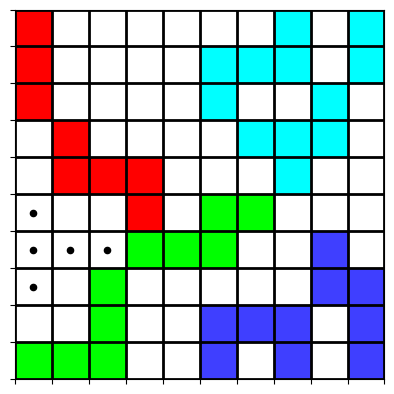

[[0.3697369  0.29480544 0.17764919 0.15780847]]
tensor([0., 0., 0., 1.])


In [101]:
boards, policies, values = test_data

# 1000 - pretty good, happy with red, shows green definitely is losing, etc

index = 700
board, policies, values = boards[index], policies[index], values[index]

display = Display(board, overlay_dots=MOVES["new_occupieds"][1118])
display.show()

values_logits_tensor, policy_logits_tensor = model(board.unsqueeze(0).to(DEVICE))
eval_values = torch.softmax(values_logits_tensor, dim=1).detach().cpu().numpy()
policy_logits = policy_logits_tensor.detach().cpu().numpy()

print(eval_values)
print(values)

In [102]:
np.argsort(policy_logits)[0][::-1][:10]

array([ 477,  362, 4234, 4061, 2809, 4355, 3469, 5587, 6049, 3953])

In [103]:
run.close()